In [1]:
# import packages 
import numpy as np 

import h5py
import os
import re

from scipy import stats
from scipy import signal
import scipy.optimize

import pickle

import matplotlib.pyplot as plt
import matplotlib.patches as mpl_patches
import matplotlib as mpl
import matplotlib.cm as mpl_cm
import matplotlib.colors as mpl_colors
import matplotlib.offsetbox as mpl_offsetbox
import matplotlib.gridspec as mpl_gridspec

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# change font
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "Arial"
mpl.rcParams.update({'font.size': 8})

print(mpl.rcParams['font.family'])
print(mpl.rcParams['font.sans-serif'])
print(mpl.rcParams['font.size'])

['Arial']
['Arial']
8.0


In [2]:
# Save progress 
HISTORY_FILEPATH = r"\\10.254.8.27\jilab2\Jian\BackUp\JupyterNotebookRemoteBackup\NeuronPairCovarianceAnalysis.py"
LAST_SAVE_TIME = 0
SAVE_INTERVAL_S = 5*60
def SAVE_PROGRESS(dst_file_path):
    global LAST_SAVE_TIME, SAVE_INTERVAL_S
    import time
    cur_time = time.time()
    if (cur_time - LAST_SAVE_TIME) < SAVE_INTERVAL_S:
        print(f"Time since last sync = {(cur_time - LAST_SAVE_TIME):0.2f} s" )
        return
    LAST_SAVE_TIME = cur_time
    try:
        from datetime import datetime
        dst_dir_path, dst_file_name = os.path.split(dst_file_path)
        dst_file_name = os.path.splitext(dst_file_name)[0] + "_" + datetime.today().strftime('%Y-%m-%d') + os.path.splitext(dst_file_name)[1]
        dst_file_path = os.path.join(dst_dir_path, dst_file_name)
        if not os.path.isdir(dst_dir_path):
            os.makedirs(dst_dir_path)
        if os.path.exists(dst_file_path):
            os.remove(dst_file_path)
        %history -t -g -f $dst_file_path
        print("Progress saved to: " + dst_file_path)
    except Exception as e:
        print("Progress sync failed, error: ",e)

In [3]:
# display configuration

my_monitor_dpi_px = 96
illustrator_mointor_dpi_px = 72
letter_paper_size_inch = np.array((8.5, 11))

# full_page_figure_illustrator_size_pxls = np.array([521, 655])
# full_page_paper_illustrator_size_pxls = np.array([620, 801])
full_page_figure_illustrator_size_pxls = np.array([521, 660])
full_page_paper_illustrator_size_pxls = np.array([612, 792])
paper_to_illustrator_ratio = full_page_figure_illustrator_size_pxls/full_page_paper_illustrator_size_pxls


SAVE_PROGRESS(HISTORY_FILEPATH)

Progress saved to: \\10.254.8.27\jilab2\Jian\BackUp\JupyterNotebookRemoteBackup\NeuronPairCovarianceAnalysis_2023-12-14.py


In [4]:
# acqusition configuration
time_per_frame_ms = 2.6 
ms_to_s = 1e-3
s_to_ms = 1e3

bw_order = 12
bw_cutoff = 50
fs = 1 * s_to_ms / time_per_frame_ms

SAVE_PROGRESS(HISTORY_FILEPATH)

Time since last sync = 11.24 s


In [5]:
src_hdf5_file_path = r"J:\2023-10-10\M377_JEDI2P\FOV03\Group01\StatsAnalysisSubtresholds_Ver05_FromVer01_20Hz5OrderBW_CorrectMeanTiming_New\stats_analysis_data.hdf5"

dst_dir_path = os.path.split(src_hdf5_file_path)[0]
dst_plot_subdir_name = "figures"
dst_data_subdir_name = "data"

SAVE_PROGRESS(HISTORY_FILEPATH)

Time since last sync = 11.25 s


In [6]:
# load source data 

nof_rois = None
nof_trials = None
nof_frames = None
nof_orients = None

stim_tstamp_s = None
stim_tstamp = None

t_test_pass_mask = None
diff_t_test_pass_mask = None
gather_t_test_pass_mask = None
anova_test_pass_mask = None
diff_anova_test_pass_mask = None

roi_spike_events = None
roi_subthd_dFFs = None
roi_spike_rates = None
snrs = None
dFF_s = None
F0_s = None
t_s = None

with h5py.File(src_hdf5_file_path, "r") as hdf5_file:
    nof_rois = hdf5_file["nof_roi"][()]
    nof_frames = hdf5_file["nof_frames"][()]
    nof_orients = hdf5_file["nof_orient"][()]
    nof_trials = hdf5_file["nof_files"][()]
    
    stim_tstamp_s = hdf5_file["stim_tstamp_s"][()]
    stim_tstamp = hdf5_file["stim_tstamp"][()]

    dFF_s = hdf5_file["dFFs"][()]
    F0_s = hdf5_file["F0"][()]
    t_s = hdf5_file["t"][()]
    snrs = hdf5_file["snrs"][()]
    
    nof_tstamps = stim_tstamp.shape[1]

    t_test_pass_mask = np.full((nof_rois,), False)
    diff_t_test_pass_mask = np.full((nof_rois,), False)
    gather_t_test_pass_mask = np.full((nof_rois,), False)
    anova_test_pass_mask = np.full((nof_rois,), False)
    diff_anova_test_pass_mask = np.full((nof_rois,), False)

    roi_spike_events = np.zeros((nof_rois, nof_trials, nof_frames))
    roi_subthd_dFFs = np.zeros((nof_rois, nof_trials, nof_frames))
    roi_spike_rates = np.zeros((nof_rois, nof_orients, nof_tstamps, nof_trials))
    
    for i_roi in range(nof_rois):
        cur_roi_str = f"roi{i_roi}"
        roi_spike_events[i_roi, :, :] = hdf5_file[os.path.join(cur_roi_str, "cur_spike_event")][()]
        roi_subthd_dFFs[i_roi, :, :] = hdf5_file[os.path.join(cur_roi_str, "cur_subthreshold_dFF")][()]
        
        t_test_pass_mask[i_roi] =  hdf5_file[os.path.join(cur_roi_str, "t_test_pass")][()]
        diff_t_test_pass_mask[i_roi] =  hdf5_file[os.path.join(cur_roi_str, "diff_t_test_pass")][()]
        gather_t_test_pass_mask[i_roi] =  hdf5_file[os.path.join(cur_roi_str, "gather_t_test_pass")][()]
        anova_test_pass_mask[i_roi] = hdf5_file[os.path.join(cur_roi_str, "anova_test_pass")][()]
        diff_anova_test_pass_mask[i_roi] = hdf5_file[os.path.join(cur_roi_str, "diff_anova_test_pass")][()]
        roi_spike_rates[i_roi,:,:,:] = hdf5_file[os.path.join(cur_roi_str, "cur_spike_rate")][()]

SAVE_PROGRESS(HISTORY_FILEPATH)

Time since last sync = 22.84 s


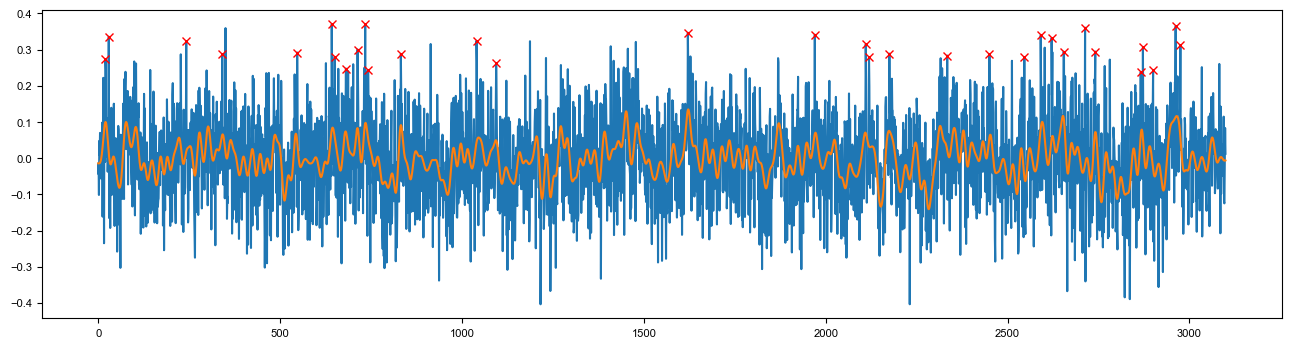

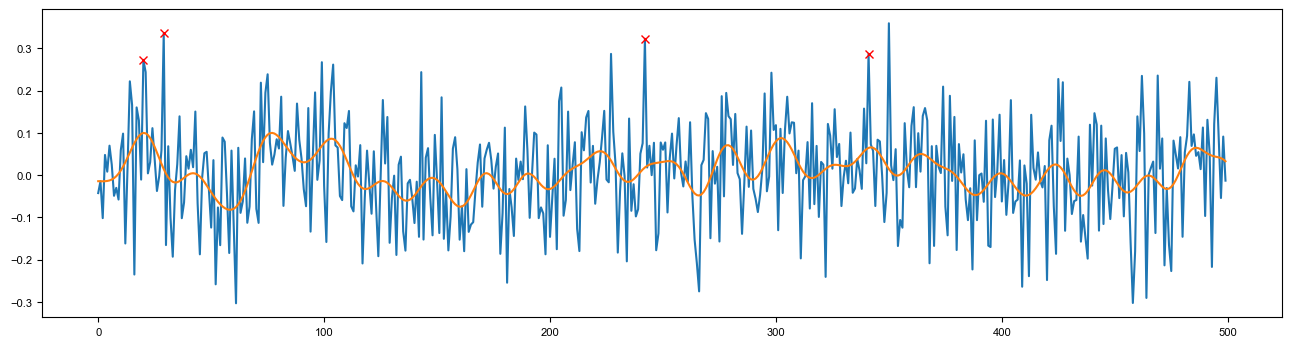

Time since last sync = 23.24 s


In [7]:
check_i_roi = 32
check_i_trial = 1

plot_x_range = [300, 800]


check_dFF =  dFF_s[check_i_roi, check_i_trial, :]
check_dFF_subthd = roi_subthd_dFFs[check_i_roi, check_i_trial, :]
check_spike_mask = roi_spike_events[check_i_roi, check_i_trial, :]

plot_xs = np.arange(len(check_dFF))

plot_spike_xs = plot_xs.copy().astype(float)
plot_spike_ys = check_dFF.copy().astype(float)
plot_spike_xs[check_spike_mask <= 0] = np.nan
plot_spike_ys[check_spike_mask <= 0 ] = np.nan
# plot_spike_xs = plot_xs[check_spike_mask > 0]
# plot_spike_ys = check_dFF[check_spike_mask > 0]

plt.figure(figsize = (16,4))
plt.plot(plot_xs, check_dFF)
plt.plot(plot_xs, check_dFF_subthd)
plt.plot(plot_spike_xs, plot_spike_ys, "rx")
plt.show()

zoom_x_range = np.arange(0, 500)
plt.figure(figsize = (16,4))
plt.plot(plot_xs[zoom_x_range], check_dFF[zoom_x_range])
plt.plot(plot_xs[zoom_x_range], check_dFF_subthd[zoom_x_range])
plt.plot(plot_spike_xs[zoom_x_range], plot_spike_ys[zoom_x_range], "rx")
plt.show()

SAVE_PROGRESS(HISTORY_FILEPATH)

In [8]:
# calculate RF-dFF points for covarience calculation

# FR_dFF_bin_size = int(20/time_per_frame_ms)
# FR_dFF_bin_size = 5
# FR_dFF_bin_size = int(10/time_per_frame_ms)
# FR_dFF_bin_size = 4
# FR_dFF_bin_size = int(np.ceil(10/time_per_frame_ms))
# FR_dFF_bin_size = 6
FR_dFF_bin_size = int(np.ceil(40/time_per_frame_ms))
pre_rm_nof_bins = int(np.ceil(100/time_per_frame_ms))

print(f"FR_dFF_bin_size = {FR_dFF_bin_size}")

input_subthd_dFF = roi_subthd_dFFs[:,:,pre_rm_nof_bins:]
input_spike_events = roi_spike_events[:,:,pre_rm_nof_bins:]

nof_rois, nof_trials, trace_len = input_subthd_dFF.shape

nof_RFdFFpair =  trace_len - FR_dFF_bin_size + 1

FRdFF_FRs = np.zeros((nof_rois, nof_trials, nof_RFdFFpair))
FRdFF_dFFs = np.zeros((nof_rois, nof_trials, nof_RFdFFpair))

for i_RFdFFpair in range(nof_RFdFFpair):
    cur_win_start = i_RFdFFpair
    cur_win_end = i_RFdFFpair + FR_dFF_bin_size
    
    cur_FRs = np.mean(input_spike_events[:,:,cur_win_start:cur_win_end] > 0, axis = -1)
    cur_dFFs = np.mean(input_subthd_dFF[:,:,cur_win_start:cur_win_end], axis = -1)

    FRdFF_FRs[:,:,i_RFdFFpair] = cur_FRs
    FRdFF_dFFs[:,:,i_RFdFFpair] = cur_dFFs

FRdFF_FRs = FRdFF_FRs/(time_per_frame_ms * ms_to_s)
    
SAVE_PROGRESS(HISTORY_FILEPATH)

FR_dFF_bin_size = 16
Time since last sync = 27.28 s


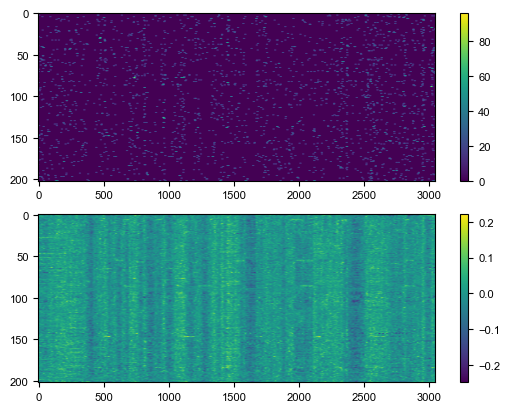

Time since last sync = 27.73 s


In [9]:
# check FR and dFF results

check_i_trial = 6

plt.figure()
plt.subplot(2,1,1)
plt.imshow(FRdFF_FRs[:,check_i_trial,:], aspect = "auto")
plt.colorbar()
plt.subplot(2,1,2)
plt.imshow(FRdFF_dFFs[:,check_i_trial,:], aspect = "auto")
plt.colorbar()
plt.show()

SAVE_PROGRESS(HISTORY_FILEPATH)

In [10]:
# calculate single trial covarience matrix
input_suprathd_FRs = FRdFF_FRs
input_subthd_dFFs = FRdFF_dFFs

nof_rois, nof_trials, _ = input_suprathd_FRs.shape

suprathd_cov_matrix = np.zeros((nof_trials, nof_rois, nof_rois))
subthd_cov_matrix = np.zeros((nof_trials, nof_rois, nof_rois))

for i_trial in range(nof_trials):
    cur_suprathd_FRs = input_suprathd_FRs[:,i_trial,:]
    suprathd_cov_matrix[i_trial, :, :] = np.cov(cur_suprathd_FRs, 
                                                rowvar = True,
                                                bias = True,
                                                ddof = 0)

    cur_subthd_dFFs = input_subthd_dFFs[:,i_trial,:]
    subthd_cov_matrix[i_trial, :, :] = np.cov(cur_subthd_dFFs,
                                              rowvar = True,
                                              bias = True,
                                              ddof = 0)

SAVE_PROGRESS(HISTORY_FILEPATH)

Time since last sync = 28.10 s


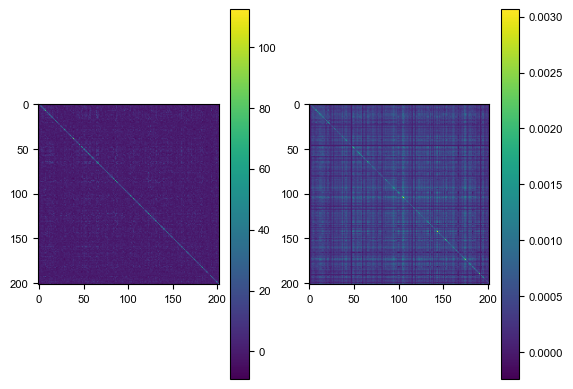

Time since last sync = 28.45 s


In [11]:
# check covarianx matrix result
check_i_trial = 0

plt.figure()
plt.subplot(1,2,1)
plt.imshow(suprathd_cov_matrix[check_i_trial, :, :])
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(subthd_cov_matrix[check_i_trial, :, :])
plt.colorbar()
plt.show()

SAVE_PROGRESS(HISTORY_FILEPATH)

In [12]:
def norm_cov_matrix(m):
    assert len(m.shape) == 2
    assert m.shape[0] == m.shape[1]
        
    norm_m = np.zeros(m.shape)
    for i_elem in range(m.shape[0]):
        for j_elem in range(m.shape[1]):
            norm_m[i_elem,j_elem] = m[i_elem,j_elem]/np.sqrt(m[i_elem,i_elem]*m[j_elem,j_elem])
    return norm_m

SAVE_PROGRESS(HISTORY_FILEPATH)

Time since last sync = 28.46 s


In [13]:
# calculated trial avg pccs matrix
input_suprathd_cov_matrix = suprathd_cov_matrix
input_subthd_cov_matrix = subthd_cov_matrix

nof_trials, nof_rois, _ = input_suprathd_cov_matrix.shape

trial_avg_suprathd_cov_matrix = np.mean(input_suprathd_cov_matrix, axis = 0)
trial_avg_subthd_cov_matrix = np.mean(input_subthd_cov_matrix, axis = 0)

trial_avg_suprathd_pcc_matrix = norm_cov_matrix(trial_avg_suprathd_cov_matrix)
trial_avg_subthd_pcc_matrix = norm_cov_matrix(trial_avg_subthd_cov_matrix)

print(np.max(trial_avg_suprathd_pcc_matrix))
print(np.min(trial_avg_suprathd_pcc_matrix))
print(np.max(trial_avg_subthd_pcc_matrix))
print(np.min(trial_avg_subthd_pcc_matrix))

SAVE_PROGRESS(HISTORY_FILEPATH)

1.0
-0.03003984079696772
1.0
-0.06574341261993626
Time since last sync = 28.58 s


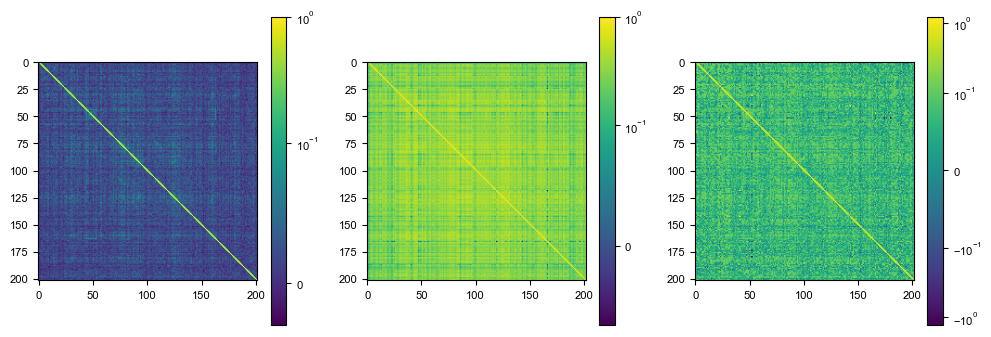

Time since last sync = 29.62 s


In [14]:
# check trial averaged pcc matrix result

plt.figure(figsize = (12,4))
plt.subplot(1,3,1)
plt.imshow(trial_avg_suprathd_pcc_matrix, 
           norm = mpl_colors.SymLogNorm(linthresh = 0.1))
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(trial_avg_subthd_pcc_matrix,
          norm = mpl_colors.SymLogNorm(linthresh = 0.1))
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(trial_avg_suprathd_pcc_matrix/trial_avg_subthd_pcc_matrix,
          norm = mpl_colors.SymLogNorm(linthresh = 0.1))
plt.colorbar()
plt.show()

SAVE_PROGRESS(HISTORY_FILEPATH)

In [15]:
def shift_correct_cov_matrix(src_ns):
    assert len(src_ns.shape) == 3
    roll_shift = -1
    
    nof_rois, nof_trials, trace_len = src_ns.shape
    roll_ns = np.roll(src_ns, roll_shift, axis = 1) 

    cov_ns = np.zeros((nof_rois,nof_rois))
    for i_roi in range(nof_rois):
        for j_roi in range(i_roi, nof_rois):
            cur_nij_prod = np.mean(src_ns[i_roi,:,:]*src_ns[j_roi,:,:], axis = -1)
            cur_roll_nij_prod = np.mean(src_ns[i_roi,:,:]*roll_ns[j_roi,:,:], axis = -1)
            cov_ns[i_roi, j_roi] = np.mean(cur_nij_prod - cur_roll_nij_prod)
            cov_ns[j_roi, i_roi] = cov_ns[i_roi, j_roi]
    return cov_ns
    
SAVE_PROGRESS(HISTORY_FILEPATH)

Time since last sync = 29.63 s


In [16]:
# calculate shift corrected conv matrix
input_suprathd_FRs = FRdFF_FRs
input_subthd_dFFs = FRdFF_dFFs

suprathd_shift_cov_matrix = shift_correct_cov_matrix(input_suprathd_FRs)
subthd_shift_cov_matrix = shift_correct_cov_matrix(input_subthd_dFFs)

suprathd_shift_pcc_matrix = norm_cov_matrix(suprathd_shift_cov_matrix)
subthd_shift_pcc_matrix = norm_cov_matrix(subthd_shift_cov_matrix)

SAVE_PROGRESS(HISTORY_FILEPATH)

Time since last sync = 47.76 s


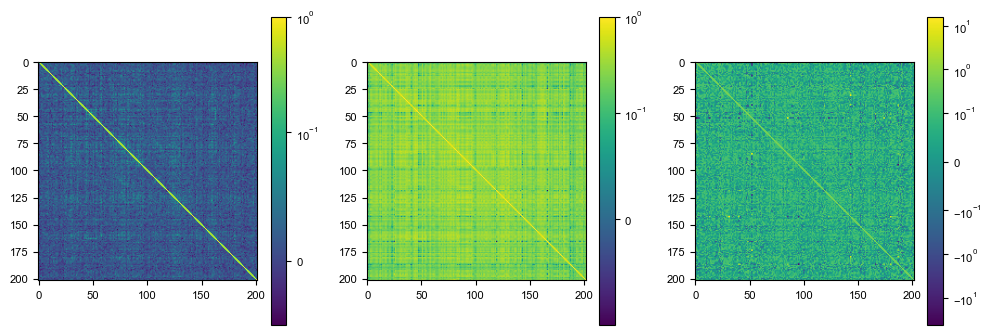

Time since last sync = 48.42 s


In [17]:
# check shift corrected pcc matrix result

plt.figure(figsize = (12,4))
plt.subplot(1,3,1)
plt.imshow(suprathd_shift_pcc_matrix, 
           norm = mpl_colors.SymLogNorm(linthresh = 0.1))
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(subthd_shift_pcc_matrix,
          norm = mpl_colors.SymLogNorm(linthresh = 0.1))
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(suprathd_shift_pcc_matrix/subthd_shift_pcc_matrix,
          norm = mpl_colors.SymLogNorm(linthresh = 0.1))
plt.colorbar()
plt.show()

SAVE_PROGRESS(HISTORY_FILEPATH)

20301
0.26791549111468793 0.016604412230897227


C:\Users\zhong\mambaforge\envs\faced_data_processing\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\zhong\mambaforge\envs\faced_data_processing\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


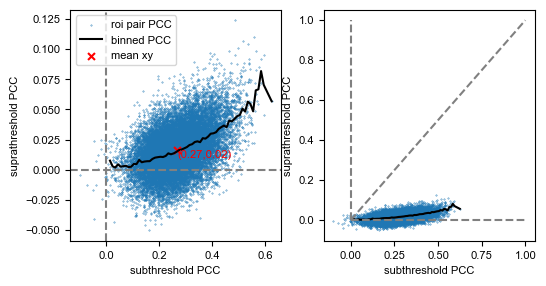

Time since last sync = 49.29 s


In [18]:
# plot subthd vs suprathd pcc scatter plot
# input_suprathd_matrix = trial_avg_suprathd_pcc_matrix
# input_subthd_matrx = trial_avg_subthd_pcc_matrix

input_suprathd_matrix = suprathd_shift_pcc_matrix
input_subthd_matrx = subthd_shift_pcc_matrix

plot_nof_rois = input_subthd_matrx.shape[0]
plot_indices = np.triu_indices(plot_nof_rois, k = 1)

plot_xs = input_subthd_matrx[plot_indices]
plot_ys = input_suprathd_matrix[plot_indices]

print(len(plot_xs))

# bin data points according to 
plot_nof_bins = 100
plot_bin_edges = np.linspace(0,1,plot_nof_bins + 1)
plot_bin_xs = (plot_bin_edges[:-1] + plot_bin_edges[1:])/2
plot_bin_ys = np.zeros((plot_nof_bins,))
for i_bin in range(plot_nof_bins):
    cur_bin_mask = np.full(plot_xs.shape, True)
    cur_bin_mask = np.logical_and(cur_bin_mask, plot_xs >= plot_bin_edges[i_bin])
    cur_bin_mask = np.logical_and(cur_bin_mask, plot_xs < plot_bin_edges[i_bin + 1])
    plot_bin_ys[i_bin] = np.mean(plot_ys[cur_bin_mask])

plot_xs_mean = np.mean(plot_xs)
plot_ys_mean = np.mean(plot_ys)

print(plot_xs_mean, plot_ys_mean)

plt.figure(figsize = (6,3))
plt.subplot(1,2,1)
plt.scatter(plot_xs, plot_ys,  s = 0.1,
           label = "roi pair PCC")
plt.plot(plot_bin_xs[plot_bin_ys > 0], plot_bin_ys[plot_bin_ys > 0], 
         color = "black",
        label = "binned PCC")
plt.axvline(0, color = "gray", linestyle = "--")
plt.axhline(0, color = "gray", linestyle = "--")
plt.scatter(plot_xs_mean, plot_ys_mean, 
            s = 25, marker = "x", color = "red",
           label = "mean xy")
plt.text(plot_xs_mean, plot_ys_mean, 
         f"({plot_xs_mean:0.2f},{plot_ys_mean:0.2f})",
         ha = "left",
         va = "top",
         color = "red")
plt.legend()
plt.xlabel("subthreshold PCC")
plt.ylabel("suprathreshold PCC")
plt.subplot(1,2,2)
plt.scatter(plot_xs, plot_ys,  s = 0.1)
plt.plot(plot_bin_xs[plot_bin_ys > 0], plot_bin_ys[plot_bin_ys > 0], color = "black")
plt.plot([0,1], [0,1], color = "gray",  linestyle = "--")
plt.plot([0,1], [0,0], color = "gray",  linestyle = "--")
plt.plot([0,0], [0,1], color = "gray",  linestyle = "--")
plt.xlabel("subthreshold PCC")
plt.ylabel("suprathreshold PCC")
plt.show()

SAVE_PROGRESS(HISTORY_FILEPATH)

In [19]:
dst_plot_subdir_path = os.path.join(dst_dir_path, dst_plot_subdir_name)

if not os.path.isdir(dst_plot_subdir_path):
    os.makedirs(dst_plot_subdir_path)

print(dst_plot_subdir_path)

dst_data_subdir_path = os.path.join(dst_dir_path, dst_data_subdir_name)

if not os.path.isdir(dst_data_subdir_path):
    os.makedirs(dst_data_subdir_path)

print(dst_data_subdir_path)

SAVE_PROGRESS(HISTORY_FILEPATH)

J:\2023-10-10\M377_JEDI2P\FOV03\Group01\StatsAnalysisSubtresholds_Ver05_FromVer01_20Hz5OrderBW_CorrectMeanTiming_New\figures
J:\2023-10-10\M377_JEDI2P\FOV03\Group01\StatsAnalysisSubtresholds_Ver05_FromVer01_20Hz5OrderBW_CorrectMeanTiming_New\data
Time since last sync = 49.32 s


In [75]:
# save processing result

dst_hdf5_file_name = "NeuronPairCovAnalysis.hdf5"
dst_hdf5_file_path = os.path.join(dst_data_subdir_path, dst_hdf5_file_name)

with h5py.File(dst_hdf5_file_path, "w") as hdf5_file:
    hdf5_file.create_dataset("src_hdf5_file_path", data = src_hdf5_file_path)
    hdf5_file.create_dataset("time_per_frame_ms", data = time_per_frame_ms)
    hdf5_file.create_dataset("ms_to_s", data = ms_to_s)
    hdf5_file.create_dataset("s_to_ms", data = s_to_ms)
    hdf5_file.create_dataset("nof_rois", data = nof_rois)
    hdf5_file.create_dataset("nof_trials", data = nof_trials)
    hdf5_file.create_dataset("nof_frames", data = nof_frames)
    hdf5_file.create_dataset("nof_orients", data = nof_orients)
    hdf5_file.create_dataset("stim_tstamp_s", data = stim_tstamp_s)
    hdf5_file.create_dataset("stim_tstamp", data = stim_tstamp)
    hdf5_file.create_dataset("t_test_pass_mask", data = t_test_pass_mask)
    hdf5_file.create_dataset("diff_t_test_pass_mask", data = diff_t_test_pass_mask)
    hdf5_file.create_dataset("gather_t_test_pass_mask", data = gather_t_test_pass_mask)
    hdf5_file.create_dataset("anova_test_pass_mask", data = anova_test_pass_mask)
    hdf5_file.create_dataset("diff_anova_test_pass_mask", data = diff_anova_test_pass_mask)
    hdf5_file.create_dataset("roi_spike_events", data = roi_spike_events)
    hdf5_file.create_dataset("roi_subthd_dFFs", data = roi_subthd_dFFs)
    hdf5_file.create_dataset("roi_spike_rates", data = roi_spike_rates)
    hdf5_file.create_dataset("snrs", data = snrs)
    hdf5_file.create_dataset("dFF_s", data = dFF_s)
    hdf5_file.create_dataset("F0_s", data = F0_s)
    hdf5_file.create_dataset("t_s", data = t_s)
    hdf5_file.create_dataset("FR_dFF_bin_size", data = FR_dFF_bin_size)
    hdf5_file.create_dataset("pre_rm_nof_bins", data = pre_rm_nof_bins)
    hdf5_file.create_dataset("FRdFF_FRs", data = FRdFF_FRs)
    hdf5_file.create_dataset("FRdFF_dFFs", data = FRdFF_dFFs)
    hdf5_file.create_dataset("suprathd_cov_matrix", data = suprathd_cov_matrix)
    hdf5_file.create_dataset("subthd_cov_matrix", data = subthd_cov_matrix)
    hdf5_file.create_dataset("trial_avg_suprathd_cov_matrix", data = trial_avg_suprathd_cov_matrix)
    hdf5_file.create_dataset("trial_avg_subthd_cov_matrix", data = trial_avg_subthd_cov_matrix)
    hdf5_file.create_dataset("trial_avg_suprathd_pcc_matrix", data = trial_avg_suprathd_pcc_matrix)
    hdf5_file.create_dataset("trial_avg_subthd_pcc_matrix", data = trial_avg_subthd_pcc_matrix)
    hdf5_file.create_dataset("suprathd_shift_cov_matrix", data = suprathd_shift_cov_matrix)
    hdf5_file.create_dataset("subthd_shift_cov_matrix", data = subthd_shift_cov_matrix)
    hdf5_file.create_dataset("suprathd_shift_pcc_matrix", data = suprathd_shift_pcc_matrix)
    hdf5_file.create_dataset("subthd_shift_pcc_matrix", data = subthd_shift_pcc_matrix)

SAVE_PROGRESS(HISTORY_FILEPATH)

Progress saved to: \\10.254.8.27\jilab2\Jian\BackUp\JupyterNotebookRemoteBackup\NeuronPairCovarianceAnalysis_2023-12-06.py


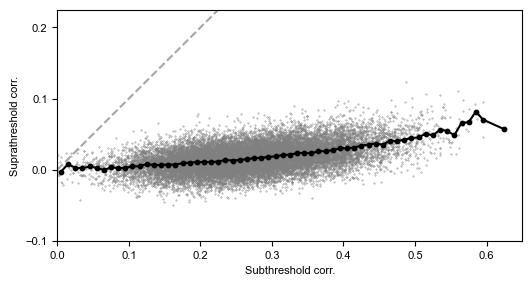

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


plot saved to: J:\2023-10-10\M377_JEDI2P\FOV03\Group01\StatsAnalysisSubtresholds_Ver05_FromVer01_20Hz5OrderBW_CorrectMeanTiming_New\figures\neuron_cov_plot_test.pdf
pickle dump to: J:\2023-10-10\M377_JEDI2P\FOV03\Group01\StatsAnalysisSubtresholds_Ver05_FromVer01_20Hz5OrderBW_CorrectMeanTiming_New\figures\neuron_cov_plot_test.pickle
data saved to: J:\2023-10-10\M377_JEDI2P\FOV03\Group01\StatsAnalysisSubtresholds_Ver05_FromVer01_20Hz5OrderBW_CorrectMeanTiming_New\figures\neuron_cov_plot_test.hdf5
Progress saved to: \\10.254.8.27\jilab2\Jian\BackUp\JupyterNotebookRemoteBackup\NeuronPairCovarianceAnalysis_2023-12-14.py


In [28]:
# make nice figure 

input_suprathd_matrix = suprathd_shift_pcc_matrix
input_subthd_matrx = subthd_shift_pcc_matrix

plot_nof_rois = input_subthd_matrx.shape[0]
plot_indices = np.triu_indices(plot_nof_rois, k = 1)

plot_xlims = np.array([-0.0, 0.65])
plot_ylims = np.array([-0.1, 0.225])

plot_xticks = np.linspace(0,0.6,7)
plot_yticks = np.linspace(-0.1,0.2,4)

dst_figure_name = r"neuron_cov_plot_test"

dst_png_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".png")
dst_eps_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".eps")
dst_pdf_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".pdf")
dst_pkl_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".pickle")
dst_hdf5_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".hdf5")
dst_notebook_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".ipynb")

plot_xs = input_subthd_matrx[plot_indices]
plot_ys = input_suprathd_matrix[plot_indices]

# bin data points according to 
plot_nof_bins = 100
plot_bin_edges = np.linspace(0,1,plot_nof_bins + 1)
plot_bin_xs = (plot_bin_edges[:-1] + plot_bin_edges[1:])/2
plot_bin_ys = np.zeros((plot_nof_bins,))
for i_bin in range(plot_nof_bins):
    cur_bin_mask = np.full(plot_xs.shape, True)
    cur_bin_mask = np.logical_and(cur_bin_mask, plot_xs >= plot_bin_edges[i_bin])
    cur_bin_mask = np.logical_and(cur_bin_mask, plot_xs < plot_bin_edges[i_bin + 1])
    plot_bin_ys[i_bin] = np.mean(plot_ys[cur_bin_mask])

plot_xs_mean = np.mean(plot_xs)
plot_ys_mean = np.mean(plot_ys)

fig = plt.figure(figsize = (6,3))
plt.scatter(plot_xs, plot_ys,  
            s = 0.1, c =  r"#808080")
# plt.plot(plot_bin_xs[plot_bin_ys > 0], plot_bin_ys[plot_bin_ys > 0], color = "black")
# plt.scatter(plot_bin_xs[plot_bin_ys > 0], plot_bin_ys[plot_bin_ys > 0], 
#             s = 10, c = "black")
plt.plot(plot_bin_xs[~np.isnan(plot_bin_ys)], plot_bin_ys[~np.isnan(plot_bin_ys)], color = "black")
plt.scatter(plot_bin_xs[~np.isnan(plot_bin_ys)], plot_bin_ys[~np.isnan(plot_bin_ys)], 
            s = 10, c = "black")
plt.axline([0,0], [0.1, 0.1], 
           color =r"#a6a6a6",  linestyle = "--")
plt.xlim(plot_xlims)
plt.xticks(ticks = plot_xticks)
plt.ylim(plot_ylims)
plt.yticks(ticks = plot_yticks)
plt.xlabel("Subthreshold corr.")
plt.ylabel("Suprathreshold corr.")
plt.show()

fig.savefig(dst_png_figure_path, format = "png", bbox_inches = 'tight')
fig.savefig(dst_eps_figure_path, format = "eps", bbox_inches = 'tight')
fig.savefig(dst_pdf_figure_path, format = "pdf", bbox_inches = 'tight')

with h5py.File(dst_hdf5_figure_path, "w") as hdf5_file:
    hdf5_file.create_dataset("input_suprathd_matrix", data = input_suprathd_matrix)
    hdf5_file.create_dataset("input_subthd_matrx", data = input_subthd_matrx)
    hdf5_file.create_dataset("plot_nof_rois", data = plot_nof_rois)
    hdf5_file.create_dataset("plot_indices", data = plot_indices)
    hdf5_file.create_dataset("plot_xs", data = plot_xs)
    hdf5_file.create_dataset("plot_ys", data = plot_ys)
    hdf5_file.create_dataset("plot_xlims", data = plot_xlims)
    hdf5_file.create_dataset("plot_ylims", data = plot_ylims)
    hdf5_file.create_dataset("plot_xticks", data = plot_xticks)
    hdf5_file.create_dataset("plot_yticks", data = plot_yticks)
    hdf5_file.create_dataset("plot_nof_bins", data = plot_nof_bins)
    hdf5_file.create_dataset("plot_bin_edges", data = plot_bin_edges)
    hdf5_file.create_dataset("plot_bin_xs", data = plot_bin_xs)
    hdf5_file.create_dataset("plot_bin_ys", data = plot_bin_ys)
    hdf5_file.create_dataset("plot_xs_mean", data = plot_xs_mean)
    hdf5_file.create_dataset("plot_ys_meann", data = plot_ys_mean)

%notebook $dst_notebook_path
                             
print("plot saved to: " + dst_pdf_figure_path)
print("pickle dump to: " + dst_pkl_figure_path)
print("data saved to: " + dst_hdf5_figure_path)

SAVE_PROGRESS(HISTORY_FILEPATH)

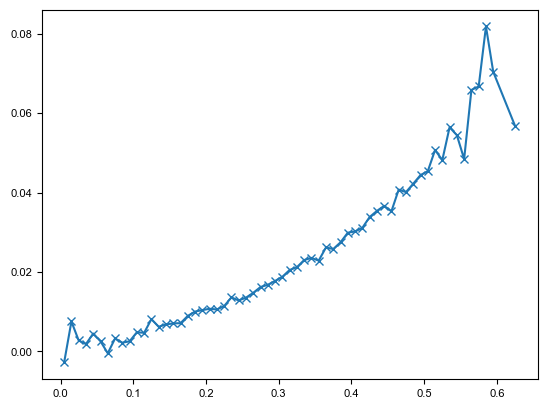

In [27]:
plt.figure()
plt.plot(plot_bin_xs[~np.isnan(plot_bin_ys)], plot_bin_ys[~np.isnan(plot_bin_ys)], "-x")
plt.show()

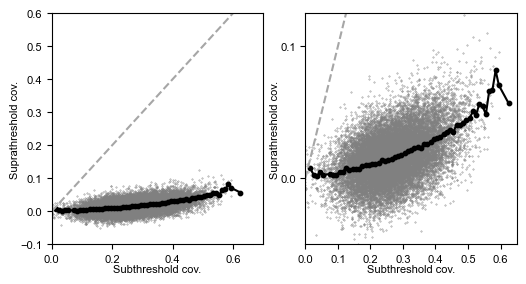

Time since last sync = 188.29 s


In [62]:
# make nice figure two view

input_suprathd_matrix = suprathd_shift_pcc_matrix
input_subthd_matrx = subthd_shift_pcc_matrix

plot_nof_rois = input_subthd_matrx.shape[0]
plot_indices = np.triu_indices(plot_nof_rois, k = 1)

plot_xlims = np.array([-0.0, 0.65])
plot_ylims = np.array([-0.05, 0.125])

plot_xtcks = np.linspace(0,0.6,7)
plot_yticks = np.linspace(0,0.1,2)

# bin data points according to 
plot_nof_bins = 100
plot_bin_edges = np.linspace(0,1,plot_nof_bins + 1)
plot_bin_xs = (plot_bin_edges[:-1] + plot_bin_edges[1:])/2
plot_bin_ys = np.zeros((plot_nof_bins,))
for i_bin in range(plot_nof_bins):
    cur_bin_mask = np.full(plot_xs.shape, True)
    cur_bin_mask = np.logical_and(cur_bin_mask, plot_xs >= plot_bin_edges[i_bin])
    cur_bin_mask = np.logical_and(cur_bin_mask, plot_xs < plot_bin_edges[i_bin + 1])
    plot_bin_ys[i_bin] = np.mean(plot_ys[cur_bin_mask])

plot_xs_mean = np.mean(plot_xs)
plot_ys_mean = np.mean(plot_ys)

plt.figure(figsize = (6,3))

plt.subplot(1,2,1)
plt.scatter(plot_xs, plot_ys,  
            s = 0.1, c =  r"#808080")
plt.plot(plot_bin_xs[plot_bin_ys > 0], plot_bin_ys[plot_bin_ys > 0], color = "black")
plt.scatter(plot_bin_xs[plot_bin_ys > 0], plot_bin_ys[plot_bin_ys > 0], 
            s = 10, c = "black")
plt.axline([0,0], [1, 1], 
           color =r"#a6a6a6",  linestyle = "--")
plt.xlim([0,0.7])
# plt.xticks(ticks = plot_xtcks)
plt.ylim([-0.1,0.6])
# plt.yticks(ticks = plot_yticks)
plt.xlabel("Subthreshold cov.", labelpad = 0)
plt.ylabel("Suprathreshold cov.", labelpad = 0)

plt.subplot(1,2,2)
plt.scatter(plot_xs, plot_ys,  
            s = 0.1, c =  r"#808080")
plt.plot(plot_bin_xs[plot_bin_ys > 0], plot_bin_ys[plot_bin_ys > 0], color = "black")
plt.scatter(plot_bin_xs[plot_bin_ys > 0], plot_bin_ys[plot_bin_ys > 0], 
            s = 10, c = "black")
plt.axline([0,0], [0.1, 0.1], 
           color =r"#a6a6a6",  linestyle = "--")
plt.xlim(plot_xlims)
plt.xticks(ticks = plot_xtcks)
plt.ylim(plot_ylims)
plt.yticks(ticks = plot_yticks)
plt.xlabel("Subthreshold cov.", labelpad = 0)
plt.ylabel("Suprathreshold cov.", labelpad = 0)

plt.show()

SAVE_PROGRESS(HISTORY_FILEPATH)